# Outline

1. A linear regression example
    - Declare variables in tensorflow
    - Run session
    - Extract results
2. A non-linear regression example
    - Add layers
    - Visualize results
3. Tensorboard
    - Visualize your neural network
    - Collect summaries during training
    
Ref:

- [A series of vedios](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/)

# 1. A linear regression example

First we consider building a simple linear regression model with $N$ data samples:
$$
\begin{aligned}
Y = X\beta + \alpha + \epsilon,
\end{aligned}
$$
where:

- $Y\in \mathbb{R}^{N}$ is the response
- $X\in \mathbb{R}^{N}$ is the only covatiate
- $\alpha$ and $\beta$ are the regression coefficients
- $\epsilon$ is the noise

In [1]:
# import libraries
import tensorflow as tf
import numpy as np

Create the data for training. Here we consider $\alpha=0.3$ and $\beta=0.1$. That is, the model would be $Y=0.1X+0.3$.

In [2]:
# number of data samples
N = 100
alpha = 0.3
beta = 0.1

# create data for Y = 0.1X + 0.3
x_data = np.random.rand(N)
y_data = x_data*beta + alpha

Next we would feed these data into the tensorflow structure. These include:

- Declare variables
- Setup optimization object function and optimizer
- Run and get results

In [3]:
# declare variables
beta = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
alpha = tf.Variable(tf.zeros([1]))

Now we have two tensorflow variables: *alpha* and *beta*. We also specify the the methods of initializing these two variables:

**tf.random_uniform([1], -1.0, 1.0)** would return an array of random number with length 1 from a uniform distribution between -1 nad 1. This first argument specify the number of random number would be generated. 

**tf.zeros([1])** would return an array of zeros with length 1.


In [4]:
# relation between input and output
y_hat = x_data*beta + alpha

# loss function
loss = tf.reduce_mean(tf.square(y_hat-y_data))

During training stage, Tensorflow would update **alpha** and **beta**. And we are trying to minimize the loss, where loss is mean squared error:
$$
\begin{aligned}
loss = \frac{1}{N}\sum_{n=1}^N (\hat{y}_n-y_n)^2
\end{aligned}
$$

In [5]:
# create optimizer, set step size to be 0.5
optimizer = tf.train.GradientDescentOptimizer(0.5) 

# The object fuction is to minimize the mean squared loss
obj = optimizer.minimize(loss)

With all of the tensorflow structure ready, we can start to traing our model:

- Initialization
- Create and run codes using session
- Get results

In [6]:
# initializer
init = tf.global_variables_initializer()

# create a session
sess = tf.Session()

# run the initializer
sess.run(init)

# run optimization and print results
for step in range(201):
    sess.run(obj)
    if step % 20 == 0:
        print("Step:%d, alpha:%f, beta:%f" % 
              (step, sess.run(alpha), sess.run(beta)))
sess.close()

Step:0, alpha:0.649393, beta:-0.217745
Step:20, alpha:0.362950, beta:-0.017989
Step:40, alpha:0.318926, beta:0.064527
Step:60, alpha:0.305690, beta:0.089335
Step:80, alpha:0.301711, beta:0.096794
Step:100, alpha:0.300514, beta:0.099036
Step:120, alpha:0.300155, beta:0.099710
Step:140, alpha:0.300046, beta:0.099913
Step:160, alpha:0.300014, beta:0.099974
Step:180, alpha:0.300004, beta:0.099992
Step:200, alpha:0.300001, beta:0.099998


## Two ways of using session

Method 1 is just he code we have seen above. Remember to close the session with **sess.close()**.

Method 2 uses the **with** statement. You should get the same results.

In [7]:
with tf.Session() as sess:
    sess.run(init)
    for step in range(201):
        sess.run(obj)
        if step % 20 == 0:
            print("Step:%d, alpha:%f, beta:%f" % 
                  (step, sess.run(alpha), sess.run(beta)))

Step:0, alpha:0.375403, beta:0.162019
Step:20, alpha:0.297714, beta:0.104116
Step:40, alpha:0.299389, beta:0.101100
Step:60, alpha:0.299837, beta:0.100294
Step:80, alpha:0.299956, beta:0.100079
Step:100, alpha:0.299988, beta:0.100021
Step:120, alpha:0.299997, beta:0.100006
Step:140, alpha:0.299999, beta:0.100001
Step:160, alpha:0.300000, beta:0.100000
Step:180, alpha:0.300000, beta:0.100000
Step:200, alpha:0.300000, beta:0.100000


## Placeholder

There is a special type of variable called placeholder. This allows you to construct the network first and feed the data afterwards.

In [8]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)

output = tf.multiply(input1, input2)

with tf.Session() as sess:
    print("Output:%f" % sess.run(output, 
                                feed_dict={input1:[7], input2:[2]}))

Output:14.000000


Compare these two lines
```python
y_hat = x_data*beta + alpha
output = tf.multiply(input1, input2)
```
The first line comes from the linear regression example. In this line, the value of **x_data** is predetermined. However, the value of **input1** and **input2** are not unkown until we feed the data when running the session. With placeholder, we could feed different data to the same network without defining the tensorflow structure again. 

# 2. A non-linear regression example

In this example, we would consider a quadratic realtion between $X$ and $Y$. Several key factors in this example:

- A function for adding layers
- Use placeholder for flexibility

## The *add_layer* function

In [9]:
def add_layer(x, in_size, out_size, activation_function=None):
    W = tf.Variable(tf.random_normal([in_size, out_size]))
    # it is recommended not initialize not to zero
    b = tf.Variable(tf.zeros([1, out_size]) + 0.1) 
    Wx_b = tf.matmul(x, W) + b
    
    if activation_function is None:
        output = Wx_b
    else:
        output = activation_function(Wx_b)
        
    return output

What does the function do:
- Create a layer with input length = *in_size*, output length = *out_size*.
- If specified, the activation function would be applied on the results.

In [10]:
# generate data samples
N = 300
x_data = np.linspace(-1, 1, N)[:, np.newaxis]
y_data = np.square(x_data) - 0.87 \
            + np.random.normal(0, 0.05, x_data.shape)

Here we generate our data $X$from -1 to 1. By using *[:, np.newaxis]*, we would obtain *x_data* as an array with shape (N, 1). Data $Y$ is generated according to the relationship:
$$
\begin{aligned}
Y = X^2 - 0.87 + \epsilon
\end{aligned}
$$
Note that we are still using linear function inside the neural network and we will see how neural network combines several linear functions and activation functions to approximate a non-linear relationship.

In [11]:
# placeholder for the tensorflow
x_input = tf.placeholder(tf.float32, [None, 1])
y_input = tf.placeholder(tf.float32, [None, 1])

layer1_output_size = 10
layer1 = add_layer(x_input, 1, layer1_output_size, 
                   activation_function=tf.nn.relu)
y_hat = add_layer(layer1, layer1_output_size, 1, activation_function=None)

Now we consider there are 10 neurons in the hidden layer (*layer1*). Thus, for *layer1*, the input size is 1 and the ouptput size is 10. The output of *layer1* would serve as the input of the output layer. Thus, the input size is 10 and the final output is the predicted value (*y_hat*) with size 1.

In [12]:
# loss function and optimizer
loss = tf.reduce_mean(tf.square(y_hat-y_input))

# optimization object function
obj = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

Like the linear regression example, we adopt mean squared error as the loss function and create a optimizer for minimization.

In [13]:
# initializer
init = tf.global_variables_initializer()

# start a session to run
with tf.Session() as sess:
    sess.run(init)
    for step in range(1001):
        sess.run(obj, feed_dict={x_input: x_data, 
                                 y_input: y_data})
        if step % 100 == 0:
            print("Step:%d, loss:%f" % 
                  (step, sess.run(loss, 
                                  feed_dict={x_input: x_data, 
                                             y_input: y_data})))
            
    # obtain the final y_hat
    y_hat = sess.run(y_hat, feed_dict={x_input: x_data,
                                       y_input: y_data})
            

Step:0, loss:0.309368
Step:100, loss:0.008168
Step:200, loss:0.006041
Step:300, loss:0.005412
Step:400, loss:0.005126
Step:500, loss:0.004926
Step:600, loss:0.004782
Step:700, loss:0.004659
Step:800, loss:0.004562
Step:900, loss:0.004472
Step:1000, loss:0.004394


Recall that we use placeholder *x_input* and *y_input* when construsting the neural network. Now we have to feed in the data using *feed\_dict*. Note that when extracting the value of *loss*, we should provide *feed\_dict* as well.

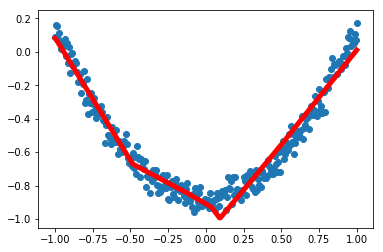

In [14]:
# a quick visualization
import matplotlib.pyplot as plt
fig = plt.figure()
plt.subplot(111)
plt.scatter(x_data, y_data)
plt.plot(x_data, y_hat, 'r-', lw=5)
plt.show()

Note: If you get a bad results or the values cannot converge, try to change the step size of the gradient descent optimizer. Step size = 0.1 should be fine in this example.

# 3. Visualization using tensorboard

Tensorboard is a useful tool for checking and visualizing your learning procedures. We would consider two useful information tensorboard could provid:

- Viasualize your neural network graph
- Obtain summaries from the training procedure

For more details, check https://www.tensorflow.org/get_started/summaries_and_tensorboard



Creating a graph of the neural network is simple. You just have to name all the variables accordingly and tensorboard would automatically generate the graph for you.

Extracting the summaries during the learning procedure is just as simple as creating the graph: you specify which variables you are interested in and tensorboard will do the rest.

In [15]:
import tensorflow as tf
import numpy as np
def add_named_layer(x, in_size, out_size, n_layer, activation_function=None):
    layer_name = "layer%s" % n_layer
    with tf.name_scope(layer_name):
        with tf.name_scope("W"):
            W = tf.Variable(tf.random_normal([in_size, out_size]), name="W")
            tf.summary.histogram(layer_name+"/W", W)
        with tf.name_scope("b"):
            b = tf.Variable(tf.zeros([1, out_size]) + 0.1, name="b") 
            tf.summary.histogram(layer_name+"/b", b)
        with tf.name_scope("Wx_b"):
            Wx_b = tf.add(tf.matmul(x, W), b)

        if activation_function is None:
            output = Wx_b
        else:
            output = activation_function(Wx_b)
            tf.summary.histogram(layer_name+"/output", output)

        return output

Now we create a new function called *add_named_layer*. The function is slightly different from the previous one: you need to provide a number for nameing the layer.

The code

```python
with tf.name_scope(your_scope_name):
```

tells tensorboard how do you want to call the container and the objects within the *with* statement would be included inside the container.

This is how *layer1* looks like
![Image of layer 1](figs/01_tensorboard_layer.png)


To collect learning summaries, we use
```python
tf.summary.histogram(histogram_name, variable_name)
```
Note that we use **tf.summary.histogram** for vectors. As for scalar, we would use **tf.summary.scalar**. We will see this in a minute.

In [16]:
N = 300
x_data = np.linspace(-1, 1, N)[:, np.newaxis]
y_data = np.square(x_data) - 0.87 \
            + np.random.normal(0, 0.05, x_data.shape)
with tf.name_scope("inputs"):
    x_input = tf.placeholder(tf.float32, [None, 1], name="x_input")
    y_input = tf.placeholder(tf.float32, [None, 1], name="y_input")

layer1 = add_named_layer(x_input, 1, 10, n_layer=1, activation_function=tf.nn.relu)
prediction = add_named_layer(layer1, 10, 1, n_layer=2, activation_function=None)

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(y_input - prediction), 
                         reduction_indices=[1]))
    tf.summary.scalar("loss", loss)
with tf.name_scope("train"):
    obj = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    
sess = tf.Session()
init = tf.global_variables_initializer()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("logs/", sess.graph)


sess.run(init)

for i in range(1000):
    sess.run(obj, 
            feed_dict={x_input: x_data, y_input: y_data})
    if i % 50 == 0:
        result = sess.run(merged, feed_dict={x_input: x_data, y_input: y_data})    
        writer.add_summary(result, i)

**Note: you might want to reset python kernel if you encounter errors**

Most of the codes are simiar, we just have to add several lines to finish the neural network structure and collect the summaries.

When everthing is all set, we want to merge every result. This includes graph and summaries. This is done by 

```python
merged = tf.summary.merge_all()
```

We also need a filewriter provided by tensorflow:
```python
writer = tf.summary.FileWriter("logs/", sess.graph)
```
This would create a file writer and the collected information would be written in the folder named *logs*. The neural network graph is passed using *sess.graph*.

Finally, we run tensorflow as usual and collect summaries using

```python
writer.add_summary(result, i)
```

### Launch tensorboard

To launch tensorboard, open a terminal and change directory to the parent path where you save the information. In our example if the folder *logs* located under *~/*, then we will do

```shell
cd ~/
tensorboard --logdir='logs/'

```
Next, open your browser and type in *http://localhost:6006/*. You can see the information collected by tensorflow.